## This scripts generate clusters for melanoma and mouse samples using ScanPy

In [23]:
import scanpy as sc

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import anndata as ad

### MELANOMA

In [4]:
mel_counts = pd.read_csv("data/Melanoma/raw.csv", index_col=0)
genes = mel_counts.columns.tolist()
spots = mel_counts.index.tolist()
rows = [int(s.split("x")[0]) for s in spots]
cols = [int(s.split("x")[1]) for s in spots]
obs_df = pd.DataFrame({"row": rows, "col": cols}, index=spots)
var_df = pd.DataFrame({"gene": genes}, index=genes)
adata_mel = ad.AnnData(X=mel_counts.values, obs=obs_df, var=var_df)

In [5]:
sc.pp.calculate_qc_metrics(adata_mel,inplace=True)

In [6]:
sc.pp.normalize_total(adata_mel, inplace=True)
sc.pp.log1p(adata_mel)
sc.pp.highly_variable_genes(adata_mel, flavor="seurat", n_top_genes=2000)

In [7]:
sc.pp.pca(adata_mel)
sc.pp.neighbors(adata_mel)
sc.tl.umap(adata_mel)
sc.tl.leiden(adata_mel, key_added="clusters")

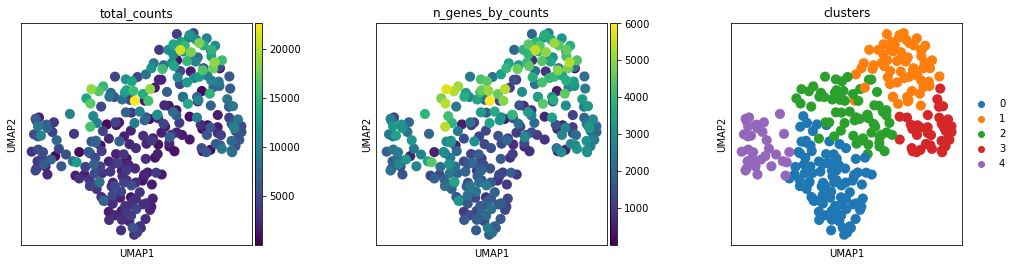

In [8]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata_mel, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

(6.0, 28.0, 29.25, 1.75)

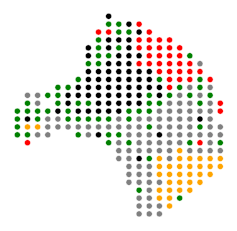

In [9]:
sns.set_style("white")
pal = {"0":"gray", "1": "black", "2": "green", "3":"red", "4":"orange"}
sns.scatterplot(data=adata_mel.obs, y='col', x='row', hue='clusters', 
                hue_order = ["0", "1", "2", "3", "4"], palette=pal)
#plt.legend(bbox_to_anchor=(1.01, 0.8))
plt.legend().remove()
plt.gca().invert_yaxis()
plt.axis("off")

## MOUSEWT DATA

In [10]:
mouse_counts = pd.read_csv("data/MouseWT/raw.csv", index_col=0)
genes = mouse_counts.columns.tolist()
spots = mouse_counts.index.tolist()
rows = [int(s.split("x")[0]) for s in spots]
cols = [int(s.split("x")[1]) for s in spots]
obs_df = pd.DataFrame({"row": rows, "col": cols}, index=spots)
var_df = pd.DataFrame({"gene": genes}, index=genes)
adata_mouse = ad.AnnData(X=mouse_counts.values, obs=obs_df, var=var_df)

In [11]:
sc.pp.calculate_qc_metrics(adata_mouse,inplace=True)
sc.pp.normalize_total(adata_mouse, inplace=True)
sc.pp.log1p(adata_mouse)
sc.pp.highly_variable_genes(adata_mouse, flavor="seurat", n_top_genes=2000)

In [12]:
sc.pp.pca(adata_mouse)
sc.pp.neighbors(adata_mouse)
sc.tl.umap(adata_mouse)
sc.tl.leiden(adata_mouse, key_added="clusters")

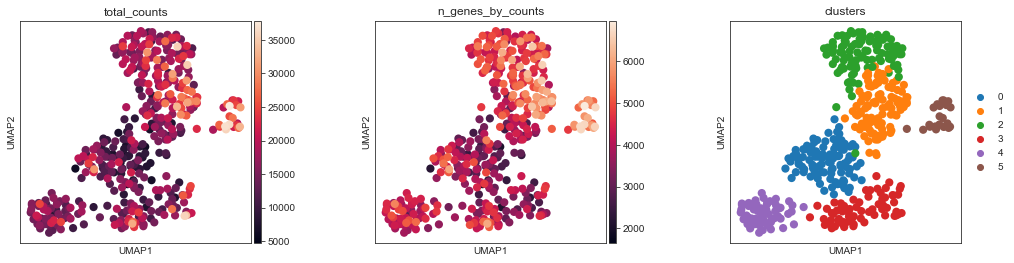

In [13]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata_mouse, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

(3.7, 32.3, 32.1, 7.9)

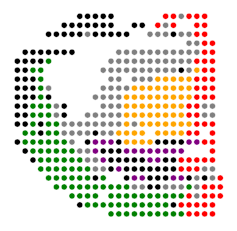

In [14]:
sns.set_style("white")
pal = {"0":"gray", "1": "black", "2": "green", "3":"red", "4":"orange", "5": "purple"}
sns.scatterplot(data=adata_mouse.obs, y='col', x='row', hue='clusters', 
                hue_order = ["0", "1", "2", "3", "4"], palette=pal)
#plt.legend(bbox_to_anchor=(1.01, 0.8))
plt.legend().remove()
plt.gca().invert_yaxis()
plt.axis("off")

In [15]:
from sklearn.metrics import adjusted_rand_score, rand_score
def ARI_score(df, cluster_col="cluster_name", min_clus_size=5):
    """Method to calculate adjusted rand index using sklearn function
        by comparing assigned spatial regions and the annotated meta info.
    """
    mouse_meta = pd.read_csv("/Users/linhuaw/Documents/AppSpatialGenes/spatialAD/spot_metadata.tsv",sep="\t",index_col=0)
    mouse_meta = mouse_meta.loc[mouse_meta.Group == "WT_12",:]
    mouse_meta["count_id"] = mouse_meta[["coord_X", "coord_Y"]].apply(lambda x: "x".join(x.astype(str)), axis=1)
    mouse_meta["region"] = mouse_meta["AT"]
    mouse_meta.loc[mouse_meta.Level_01 == "CX","region"] = "CX"
    mouse_meta = mouse_meta[["count_id", "region"]]
    mouse_meta.set_index("count_id", inplace=True, drop=True)
    
    df_region_size_dict = dict(zip(df[cluster_col].value_counts().index.tolist(),
                          df[cluster_col].value_counts().tolist()))

    df['size'] = [df_region_size_dict[k] for k in df[cluster_col].tolist()]

    df = df.loc[df["size"] >= min_clus_size,:]
    
    mouse_meta = mouse_meta.loc[df.index,:]
    print(df.shape)
    return adjusted_rand_score(mouse_meta.region.tolist(), df[cluster_col].tolist())

In [18]:
#MIST_regions = pd.read_csv("/Users/linhuaw/Desktop/mouseWT_regions.csv", index_col=0)
#print(MIST_regions)
min_clus_size=5
# spots = MIST_regions.index[MIST_regions['size']>=min_clus_size].tolist()
# print(ARI_score(MIST_regions, min_clus_size=5), len(spots))

# #mouse_regions.loc[mouse_regions['size'] >= 5]
# #mouse_regions= mouse_regions.loc[mouse_regions['size'] >= 5, :]

In [19]:
bs_regions = pd.read_csv("/Users/linhuaw/Documents/GitHub/MIST_manuscript/BayesSpace_MouseWT_clusters.csv", index_col=0)
print(ARI_score(bs_regions, "spatial.cluster"), ARI_score(bs_regions.loc[spots, :], "spatial.cluster", min_clus_size))

(447, 7)
(447, 7)
0.5427702556748414 0.5427702556748414


In [20]:
ARI_score(adata_mouse.obs, "clusters", min_clus_size), ARI_score(adata_mouse.obs.loc[spots, :], "clusters",min_clus_size)

(447, 12)
(447, 12)


(0.35550720522110885, 0.35550720522110885)

In [21]:
scanpy_cluster_df = adata_mouse.obs[['row', 'col', 'clusters']]
scanpy_cluster_df.to_csv("sp_Mouse_clusters.csv")

In [22]:
scanpy_cluster_df2 = adata_mel.obs[['row', 'col', 'clusters']]
scanpy_cluster_df2.to_csv("sp_Melanoma_clusters.csv")